In [3]:
from gurobipy import *
import numpy as np
import pandas as pd
from scipy.spatial import distance
from itertools import chain, combinations
import matplotlib.pyplot as plt
import os, sys


In [9]:
class Data:
    def __init__(self):
        self.customerNum = 0 
        self.nodeNum     = 0 
        self.droneNum    = 2
        self.cities      = []
        self.cor_X       = [] 
        self.cor_Y       = [] 
        self.serviceTime = [] 
        self.disMatrix   = [[]]
        self.dt          = None
        self.i_pot = None
        self.cus_can_served_by_drone = None
        self.drone_distances = None
        self.truck_distances = None
        self.model = None
      
        

    def readData(self, path):
        self.dt = pd.read_csv(path, header = None).to_numpy()[:-1]
        self.customerNum = len(self.dt) - 1
        self.i_pot = self.dt[0, 1:3]
        self.nodeNum = self.customerNum + 1
        self.cor_X = [self.dt[i, 1:3][0] for i in range(len(self.dt))]
        self.cor_Y = [self.dt[i, 1:3][1] for i in range(len(self.dt))]
        self.cities = [self.dt[i, 0] for i in range(len(self.dt))]
        
        self.cus_can_served_by_drone = [i for i in range(len(self.dt)) if self.dt[i, 3] == 0]
        
        self.drone_distances = [round(distance.euclidean((self.dt[i, 1:3]), self.i_pot),2)
                                if self.dt[i, 3] == 0 else float('inf')
                                for i in range(len(self.dt))]
        self.truck_distances = [[round(distance.cityblock(self.dt[i, 1:3], self.dt[j, 1:3]),1)
                                 for i in range(len(self.dt))] for j in range(len(self.dt))]
    
        for i in range(len(self.dt)):
            self.truck_distances[i].append(self.truck_distances[i][0])
        
        #Decision variables

        # x_ij if (i->j) in vehicle tour
        # # y_im = 1 if cus i assigned to drone m ()

        self.x = None  
        self.y = None 
    def addConstrs(self):


            #SET
            C = [i for i in range (1, self.customerNum + 1)] #C
            
            N = [i for i in range(self.customerNum + 2)]     #N
            
            N0 = [i for i in range(self.customerNum + 1)]    #N_0
            
            N_plus = [i for i in range (1, self.customerNum + 2)] # N_d
               
            U = [k for k in range(self.droneNum)]
            G = [0] + C
            C_U = data.cus_can_served_by_drone

            self.x = {}
            self.y = {}
            self.u = {}
            
            
            #1
            #completion time
            alpha = self.model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, "traveltime")
            self.model.update()
            expr = LinExpr(0)
            expr.addTerms(1.0, alpha)

            self.model.setObjective(expr, GRB.MINIMIZE)
            expr.clear()
            #add vars u[i]
            for i in N_plus:
                self.u[i] = self.model.addVar( vtype = GRB.INTEGER, name = "u%d" %i)
            #2
            expr = LinExpr(0)
            for i in N0:
                for j in N_plus:
                    if i != j:
                        self.x[i,j] = self.model.addVar(0, 1, vtype = GRB.BINARY,name = "x%d,%d" %(i,j))

                        self.model.update()
                        expr.addTerms(self.truck_distances[i][j], self.x[i,j])
                    else:
                        self.x[i,i] = self.model.addVar(0.0, 1.0, 0.0, GRB.BINARY, "x%d,%d" %(i,j))

    #         print(expr)

            self.model.addConstr(alpha >= expr, "truckTime")
            expr.clear()
            self.model.update()



            #3
            for k in U:
                expr = LinExpr(0)
                for i in C:

                    if i in C_U:
                        self.y[k,i] = self.model.addVar(0,1, vtype= GRB.BINARY, name =  "y%d,%d" %(k,i))
    #                     print(i)

                        expr.addTerms(self.drone_distances[i], self.y[k,i])
                    else:
                        self.y[k,i] = self.model.addVar(0, 0, vtype = GRB.BINARY, name = "y%d,%d" %(k,i))
                self.model.update()
    #             print(expr)
                self.model.addConstr(alpha >= expr, "dronetime")
                expr.clear()
            expr.clear()    


            #4
            for j in C:

                expr1 = LinExpr(0)
                expr2 = LinExpr(0)

                for i in N0:
                    if i != j:
                        expr1.addTerms(1.0, self.x[i,j])
    #                 print(expr1)

                if j in C_U:
                    for k in U:
                        expr2.addTerms(1.0, self.y[k,j])

    #             print(expr2)
    #             print("------------------")

                self.model.addConstr(expr1 + expr2 == 1, "served customer once")
                expr1.clear()
                expr2.clear()
            expr1.clear()
            expr2.clear()


            #5
#             for i in N0:

#                 expr1 = LinExpr(0)
#                 expr2 = LinExpr(0)

#                 for j in C:

#                     expr1.addTerms(1.0, self.x[i,j])
#     #             print(expr1)
#                 if i in C_U:
#                     for k in U:
#                         expr2.addTerms(1.0, self.y[k,i])

#     #             print(expr2)
#     #             print("------------------")
#                 self.model.addConstr(expr1 + expr2 == 1, "served customer once")
#                 expr1.clear()
#                 expr2.clear()
#             expr1.clear()
#             expr2.clear()


            #6
            for j in C:
                expr1 = LinExpr(0)
                expr2 = LinExpr(0)

                for i in N0:
                    if i != j:

                        expr1.addTerms(1.0, self.x[i,j])

                for h in N_plus:
                    if h != j:
                        expr2.addTerms(1.0, self.x[j,h])
                self.model.addConstr(expr1 == expr2, "flow conservation")
                expr1.clear()
                expr2.clear()
            expr1.clear()
            expr2.clear()

            #

#             #get all subtours
#             def powerset(iterable):
#                 "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#                 s = list(iterable)
#                 return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#             S = list(powerset(range(1, len(data.cities))))
#             # The first element of the list is the empty set and the last element is the full set, hence we remove them.
#             S = S[1:(len(S))]
#             S = [list(s) for s in S]

#     #         print(len(S))
#     #         import sys
#     #         print(sys.getsizeof(S)/1024/1024," GB")
#     #         print(type(S))



#             # for s in S:

#             #         s.insert(0,0)
#             S.insert(0,[0])
#             S = S[0:len(S) -1 ]
#             # print(S)
#             # S = [[0,1,2,3,4]]


#             #7
#             for s in S:
#                 expr1 = LinExpr(0)
#                 expr2 = LinExpr(0)

#                 for i in s:
#                     for j in V:
#                         if j not in s:
#                             expr1.addTerms(1.0, self.x[i,j])

#                     for k in U:
#                         if i in C_U:
#                             expr2.addTerms(1.0, self.y[k,i])
#                 self.model.update()
#     #     print(expr1)
#     #     print(expr2)
#                 self.model.addConstr(expr1 + expr2 >= 1)
#                 expr1.clear()
#                 expr2.clear()
                
            #8
            expr = LinExpr(0)
            
            for i in N_plus:
                expr.addTerms(1.0, self.x[0,i])
            self.model.addConstr(expr == 1)
           
            expr.clear()        
            #9
            
            expr = LinExpr(0)
            
            for i in N0:
                expr.addTerms(1.0, self.x[i, self.customerNum + 1])
            self.model.addConstr(expr == 1)
            expr.clear()
            
            
            
            #9
            for i in C:
                for j in N_plus:
                    if i!=j:
                        self.model.addConstr((self.u[i] - self.u[j] + 1) <= (self.customerNum  + 2)*( 1 - self.x[i,j]) )
            #10
            for i in N_plus:
                self.model.addConstr(1 <= self.u[i])
                self.model.addConstr(self.u[i] <= self.customerNum + 2)
                
            

In [10]:

path = "C:\\Users\\thebl\\Documents\\PDSTSP_MILP_new\\PDSTSP_20_customer_problems"
dirs = os.listdir(path)
problems_list = [file for file in dirs]

print(problems_list)

['20140813T124847.csv', '20140813T124849.csv', '20140813T124853.csv', '20140813T124856.csv', '20140813T124858.csv', '20140813T124902.csv', '20140813T124907.csv', '20140813T124909.csv', '20140813T124912.csv', '20140813T124915.csv', '20140813T124917.csv', '20140813T124920.csv', '20140813T124922.csv', '20140813T124924.csv', '20140813T124926.csv', '20140813T124928.csv', '20140813T124931.csv', '20140813T124933.csv', '20140813T124935.csv', '20140813T124937.csv', '20140813T124939.csv', '20140813T124941.csv', '20140813T124944.csv', '20140813T124946.csv', '20140813T124948.csv', '20140813T124950.csv', '20140813T124952.csv', '20140813T124954.csv', '20140813T124957.csv', '20140813T124959.csv', '20140813T125001.csv', '20140813T125003.csv', '20140813T125006.csv', '20140813T125008.csv', '20140813T125010.csv', '20140813T125012.csv', '20140813T125015.csv', '20140813T125017.csv', '20140813T125020.csv', '20140813T125022.csv', '20140813T125025.csv', '20140813T125027.csv', '20140813T125030.csv', '20140813T

In [2]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
for prob in problems_list:
    data = Data()
    data.model = Model("PDSTSP")
    data.readData("PDSTSP_20_customer_problems/" + prob)
    data.addConstrs()
    # data.model.setParam("NodefileStart", 0.5)
    data.model.setParam("TimeLimit", 300)
    # data.model.setParam("Threads", 8)
    data.model.optimize()
    obj = []
    runtime = []
    gap = []
    df = pd.DataFrame()
    runtime.append(data.model.Runtime)
    obj.append(data.model.ObjVal)
    gap.append(data.model.MIPGap)
    df['obj'] = obj
    df['runtime'] = runtime
    df['gap'] = gap
    df.to_csv(dir_path + '/new_Results/20/3/' + prob, index = False, header=False)

NameError: name 'os' is not defined

In [11]:
data = Data()
data.model = Model("PDSTSP")
data.readData("C:\\Users\\thebl\\Documents\\PDSTSP_MILP_new\\PDSTSP_20_customer_problems\\" + problems_list[0])
data.addConstrs()

data.model.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 444 rows, 459 columns and 2693 nonzeros
Model fingerprint: 0x8629690e
Variable types: 1 continuous, 458 integer (438 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 152.6000001
Presolve removed 40 rows and 26 columns
Presolve time: 0.01s
Presolved: 404 rows, 433 columns, 2560 nonzeros
Found heuristic solution: objective 152.6000000
Variable types: 0 continuous, 433 integer (413 binary)

Root relaxation: objective 3.461342e+01, 125 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   34.61342    0   28  152.60000   34.61342  77

In [14]:
data.model.printAttr('X')


    Variable            X 
-------------------------
  traveltime           57 
          u1            1 
          u2           21 
          u3           20 
          u4           21 
          u5           14 
          u6            1 
          u7           13 
          u8           21 
          u9           18 
         u10           21 
         u11           12 
         u12           21 
         u13           15 
         u14           16 
         u15           17 
         u16            1 
         u17           21 
         u18           19 
         u19           21 
         u20           21 
       x0,11            1 
       x3,20            1 
       x5,13            1 
        x7,5            1 
       x9,18            1 
       x11,7            1 
      x13,14            1 
      x14,15            1 
       x15,9            1 
       x18,3            1 
        y0,4            1 
        y0,6            1 
        y0,8            1 
       y0,10            1 
 

[(0, 11), (3, 20), (5, 13), (7, 5), (9, 18), (11, 7), (13, 14), (14, 15), (15, 9), (18, 3)]


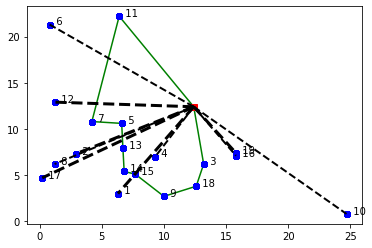

In [15]:
N0 = [i for i in range(data.customerNum + 1)]            
            
N_plus = [i for i in range (1, data.customerNum + 2)]
truck_tours = [(i,j) for i in N0 for j in N_plus if data.x[i,j].x > 0.99 ]
print(truck_tours)
U = [k for k in range(data.droneNum)]

C_U = data.cus_can_served_by_drone

plt.plot(data.i_pot[0], data.i_pot[1], c='r', marker='s')
# plt.scatter(xc[1:], yc[1:], c='b')
for i in range(1, data.customerNum + 1):
    plt.scatter(data.cor_X, data.cor_Y, c='b')
    plt.annotate(str("  ") + str(int(data.cities[i])), (data.cor_X[i], data.cor_Y[i]))
    
for i, j in truck_tours:
    if j != data.customerNum + 1:
        plt.plot([data.cor_X[i], data.cor_X[j]], [data.cor_Y[i], data.cor_Y[j]], c='g', zorder=0)
    else:
        for k, h in truck_tours:
            if h == i:
                plt.plot([data.cor_X[i], data.cor_X[0]], [data.cor_Y[i], data.cor_Y[0]], c='g', zorder=0)
        
    
default_width = 1

for k in U:
    default_width+= 1
    for i in C_U:
        if data.y[k,i].x > 0.99:
            plt.plot([data.i_pot[0],data.cor_X[i]], [data.i_pot[1], data.cor_Y[i]], color='black', linestyle='dashed', linewidth = default_width)

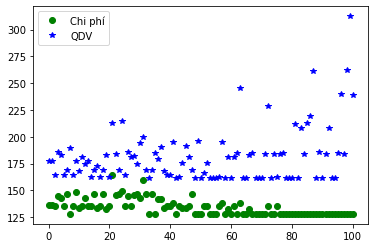

In [44]:
import matplotlib.pyplot as plt
f = open('/home/sen/new_MILP/pdsvrp_agri_milp+heuristic/result/new8k2','rt') 
lines=f.readlines()
obj=[]
qdv =[]
for x in lines:
    obj.append(float(x.split(',')[0].strip()))
    qdv.append(float(x.split(',')[1].strip()))
plt.plot(obj,'go', label = "Chi phí")
plt.plot(qdv,'b*', label = "QDV")
plt.legend(loc = 'upper left')
plt.show()
